## Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL-challenge-2

Mounted at /gdrive
/gdrive/My Drive/AN2DL-challenge-2


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Importing Data

In [ ]:
padded_data = np.load('training_dataset/training_data.npy').astype(np.float32)
valid_idx = np.load('training_dataset/valid_periods.npy').astype(int)
labels = np.load('training_dataset/categories.npy')

print('The dataset is composed by %d samples of length %d t' %(padded_data.shape[0] , padded_data.shape[1]))
print('The dataset has %d indexes for each time series, before the first and after the second it s all zeros' %(valid_idx.shape[1]))
print('The dataset has %d labels' %(labels.shape[0]))

The dataset is composed by 48000 samples of length 2776 t
The dataset has 2 indexes for each time series, before the first and after the second it s all zeros
The dataset has 48000 labels


## Exploring Data

In [ ]:
#plotting an example for each class from the order-th element of each class
def print_examples (padded_data = padded_data , valid_idx = valid_idx, labels = labels, order = 0 , instances = 1):
    classes = ['A' , 'B' , 'C' , 'D' , 'E' , 'F']
    idx = np.zeros(shape= (len(classes) , instances) , dtype=int)
    for i in range(len(classes)):
        a = np.where(labels == classes[i])[0][order : order + instances]
        idx[i] = a
    _ , axs = plt.subplots(2,3 , figsize = (18,10))
    axs = axs.reshape((-1,))
    for i in range(len(classes)):
        for j in range(instances):
            index = idx[i][j]
            start = valid_idx[index][0]
            stop = valid_idx[index][1]
            if (j == 0):
                axs[i].plot(padded_data[index,start:stop] , label = classes[i])
            else:
                axs[i].plot(padded_data[index,start:stop])
        axs[i].legend()

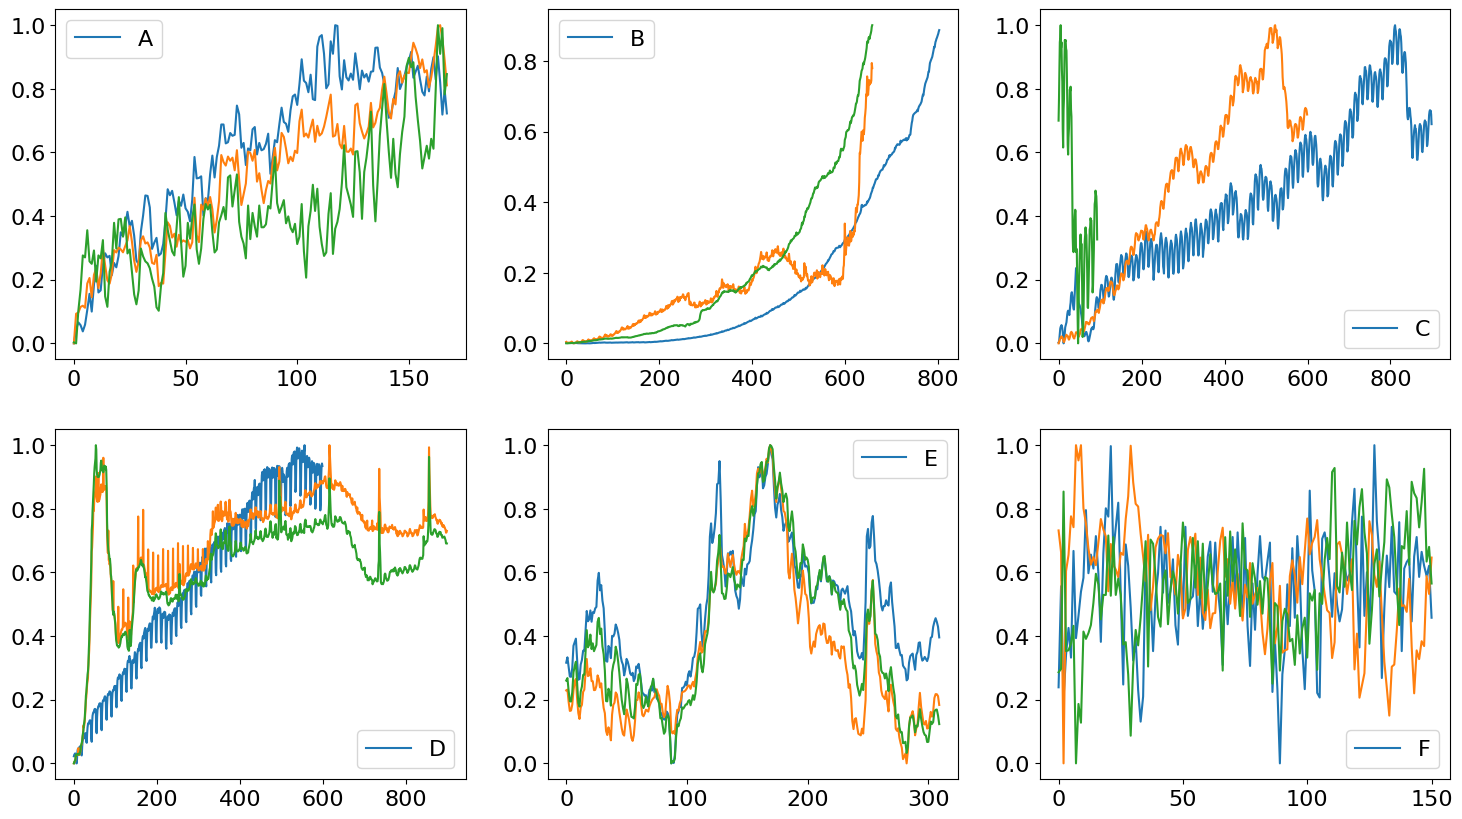

In [ ]:
# We can see that in the various labels the signals can be very eterogeneous
print_examples(order = 10 ,instances = 3)

We notice a few things:
* series from A have clearly increasing average
* series from B seem random
* series from C seem uncorrelated
* series from D have very different lengths
* series from E are very correlated but have a sesonality
* series from F seem to be stationaty but with mean different from 0 or be very slow exponential curves

In [ ]:
#We notice that the data for different labels is highly unbalanced
classes , counts = np.unique(labels , return_counts=True)
classes_counts = dict(zip(classes, counts))
for element, count in classes_counts.items():
    print(f"Element {element}: Count {count}")

Element A: Count 5728
Element B: Count 10987
Element C: Count 10017
Element D: Count 10016
Element E: Count 10975
Element F: Count 277


## Data Preprocessing

* creation of sample time series of length 200 with labels
* trend and seasonality removal
* saving trend and seasonality for posterior addition
* calculation of autocorrelation and density
* division in training and testing data

In [ ]:
# getting samples of window and stride from category label with a prevision horizon of telescope length

def sample_generation (data, label , window = 200 , stride = 2 , telescope = 50):
    assert window % stride == 0
    classes , counts = np.unique(labels , return_counts=True)
    classes_counts = dict(zip(classes, counts))
    data_used = data[np.argwhere(labels == label)].reshape(classes_counts[label] , -1)
    indexes = valid_idx[np.argwhere(labels == label)].reshape(classes_counts[label] , -1)
    samples = []
    prediction_samples = []
    for i in range(data_used.shape[0]):
        row = data_used[ i , indexes[i,0]: indexes[i,1]]
        length = row.shape[0]
        need_padding = ( length  % window ) != 0
        temp_data = row
        temp_pred = row
        if need_padding:
            padding_len = window - length % window
            padding = np.zeros((padding_len)).astype(np.float32)
            temp_data = np.concatenate((padding , row))
            temp_pred = np.concatenate((padding , row))
            assert len(temp_data) % window == 0

        for j in np.arange(0 , len(temp_data) - window - telescope , stride):
            samples.append(temp_data[j : j + window ])
            prediction_samples.append(temp_pred[ j + window : j + window + telescope])

    samples = np.array(samples)
    print('The number of samples for class' , label , 'is: ' , samples.shape[0])
    prediction_samples = np.array(prediction_samples)

    return samples , prediction_samples

In [ ]:
# describing the datastructure holding the sequences

window = 200
telescope = 18

sample_dictionary = {}
strides = [10 , 10 , 10 , 10 , 10 , 1]
stride = {k:v  for k,v in zip(classes , strides)}
for element in classes:
    samples , pred = sample_generation(padded_data , element ,window , stride = stride[element] , telescope = telescope)
    value = [samples , pred]
    sample_dictionary[element] = value

The number of samples for class A is:  100013
The number of samples for class B is:  78900
The number of samples for class C is:  119283
The number of samples for class D is:  128456
The number of samples for class E is:  86697
The number of samples for class F is:  25800


In [ ]:
raw_data = np.zeros((1,window))
pred_data = np.zeros((1,telescope))
class_data = np.array('A')

for element , value  in sample_dictionary.items():
    raw_data = np.concatenate ((raw_data , value[0]) , axis = 0)
    pred_data = np.concatenate ((pred_data , value[1]) , axis = 0)
    a = np.full (value[0].shape[0] , element)
    class_data = np.append(class_data , a)

raw_data = raw_data[1:]
pred_data = pred_data[1:]
class_data = class_data[1:]
print(raw_data.shape)
print(pred_data.shape)
print(class_data.shape)

(539149, 200)
(539149, 18)
(539149,)


In [ ]:
# train , validation and testing split

X_train ,X_test , y_train , y_test , train_class ,test_class = train_test_split(raw_data , pred_data , class_data ,  test_size= 0.2 , stratify = class_data)
print(X_train.shape , X_test.shape  ,train_class.shape , y_train.shape ,  y_test.shape, test_class.shape)
# X_train , X_val , y_train , y_val = train_test_split(X_train_val , y_train_val , test_size = len(y_test) , stratify = X_class )
# print(X_train.shape , X_val.shape , y_train.shape , y_val.shape)

(431319, 200) (107830, 200) (431319,) (431319, 18) (107830, 18) (107830,)


In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((431319, 200, 1), (431319, 18, 1), (107830, 200, 1), (107830, 18, 1))

##Training single class

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 200

In [ ]:
tf.keras.backend.clear_session()
del model

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    #x = tfkl.LSTM(64, return_sequences=True)(input_layer)

    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1')(x)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv2')(x)

    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv1 (Conv1D)              (None, 200, 64)           24640     
                                                                 
 conv2 (Conv1D)              (None, 200, 128)          24704     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                   

Here the code is changed according to which class we are examining, weights are saved in a different file each time

In [ ]:
#select data with class A, then B, C, ....saving the corresponding weights

X_train_current = X_train[train_class == 'F']
y_train_current = y_train[train_class == 'F']


In [ ]:
# Train the model
history = model.fit(
    x = X_train_current,
    y = y_train_current,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.9)
    ]
).history

model.save('my_model_weights_F.h5')

Epoch 1/200
146/146 [==============================] - 14s 32ms/step - loss: 0.0864 - val_loss: 0.0791 - lr: 0.0010
Epoch 2/200
146/146 [==============================] - 3s 23ms/step - loss: 0.0743 - val_loss: 0.0696 - lr: 0.0010
Epoch 3/200
146/146 [==============================] - 3s 20ms/step - loss: 0.0591 - val_loss: 0.0742 - lr: 0.0010
Epoch 4/200
146/146 [==============================] - 4s 25ms/step - loss: 0.0685 - val_loss: 0.0611 - lr: 0.0010
Epoch 5/200
146/146 [==============================] - 5s 37ms/step - loss: 0.0328 - val_loss: 0.0144 - lr: 0.0010
Epoch 6/200
146/146 [==============================] - 4s 29ms/step - loss: 0.0136 - val_loss: 0.0124 - lr: 0.0010
Epoch 7/200
146/146 [==============================] - 3s 22ms/step - loss: 0.0130 - val_loss: 0.0129 - lr: 0.0010
Epoch 8/200
146/146 [==============================] - 3s 22ms/step - loss: 0.0116 - val_loss: 0.0145 - lr: 0.0010
Epoch 9/200
146/146 [==============================] - 4s 28ms/step - loss: 0.0

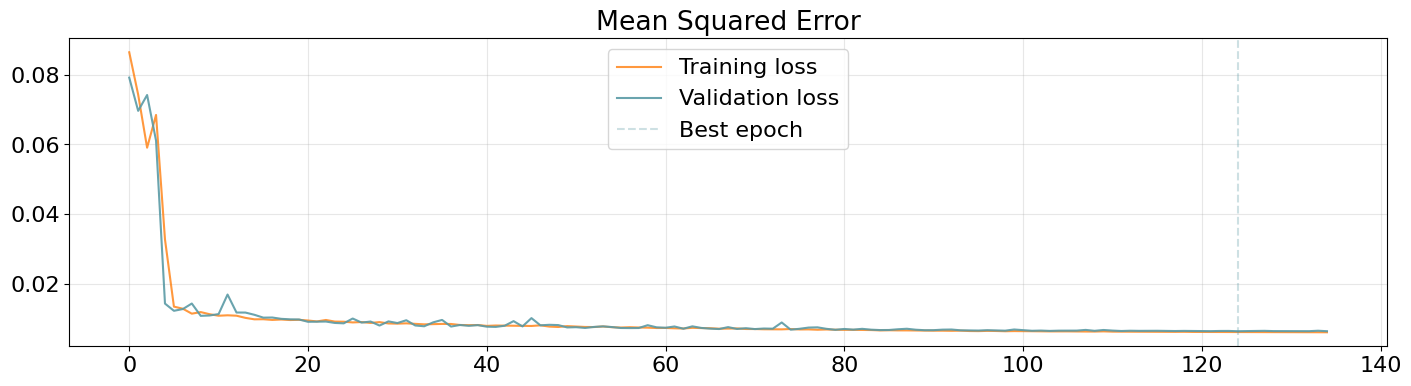

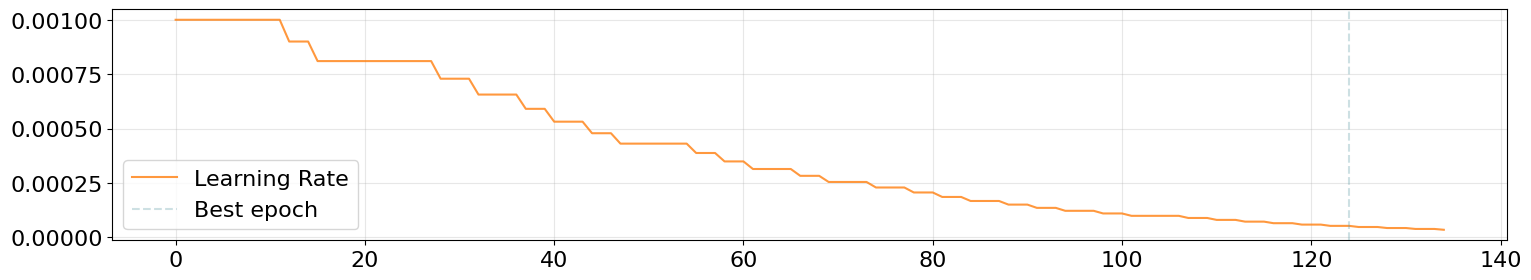

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

##Test evaluation

Here the code is changed according to which class we are examining, the difference is only in the class we are selecting for testing

In [ ]:

X_test = X_test[test_class == 'F']
y_test = y_test[test_class == 'F']

# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (5160, 18, 1)
Mean Squared Error: 0.006827080622315407
Mean Absolute Error: 0.04629182815551758


In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:],axis=1),y],axis=1)

    for i, col in enumerate(columns):
        plt.plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        plt.plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        plt.plot(np.arange(len(X[0,:,i])-1, len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
    plt.show()

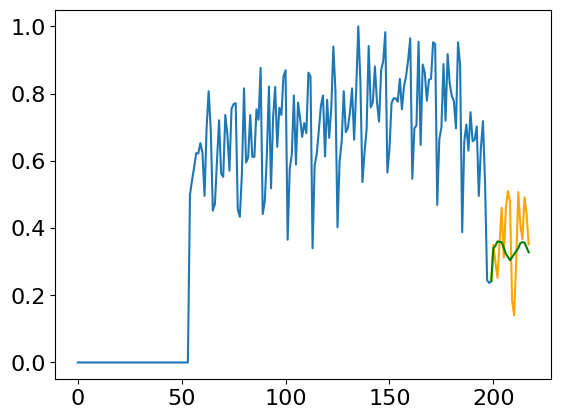

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, ["prediction"], telescope)